In [1]:
import pandas as pd

# Load DF:
df = pd.read_csv('data/king_country_houses.csv')

# Initial check:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Handle missing values:
df = df.dropna(subset=['price'])

# Remove duplicate rows:
df = df.drop_duplicates()

# Convert 'date' column to datetime:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

# Filter houses by price (650k):
df_filtered = df[df['price'] >= 650000]

# Check data:
print(df.info())

# Calculate correlation matrix:
correlation_matrix = df.corr()
print(correlation_matrix['price'].sort_values(ascending=False))

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     lo

In [2]:
print(correlation_matrix['price'].sort_values(ascending=False))

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
date            -0.004357
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64


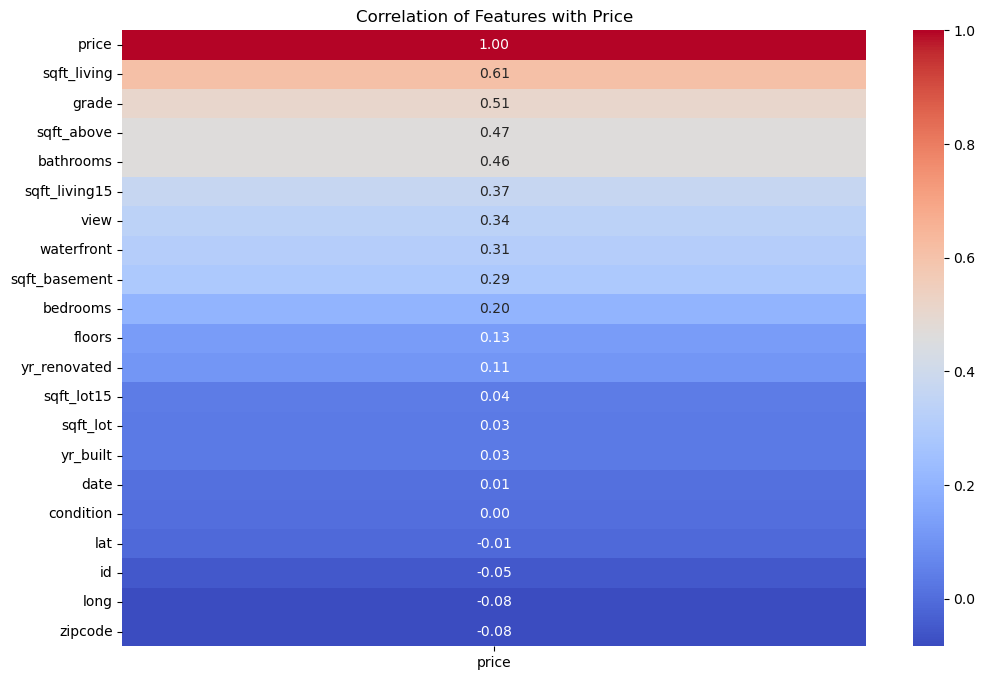

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix:
correlation_matrix = df_filtered.corr()

# Visualize correlation matrix with heatmap:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with Price')
plt.show()

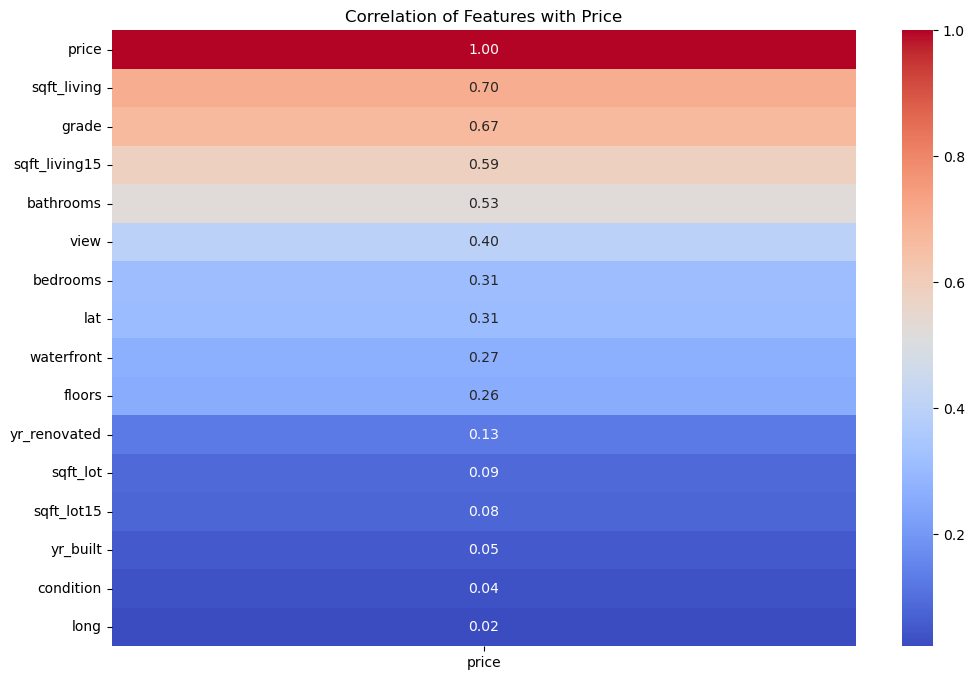

In [4]:
# Drop selected features:
df = df.drop(columns=['id', 'date', 'zipcode', 'sqft_above', 'sqft_basement'])

# Recalculate correlation matrix:
correlation_matrix = df.corr()

# Visualize correlation matrix with heatmap:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Features with Price')
plt.show()

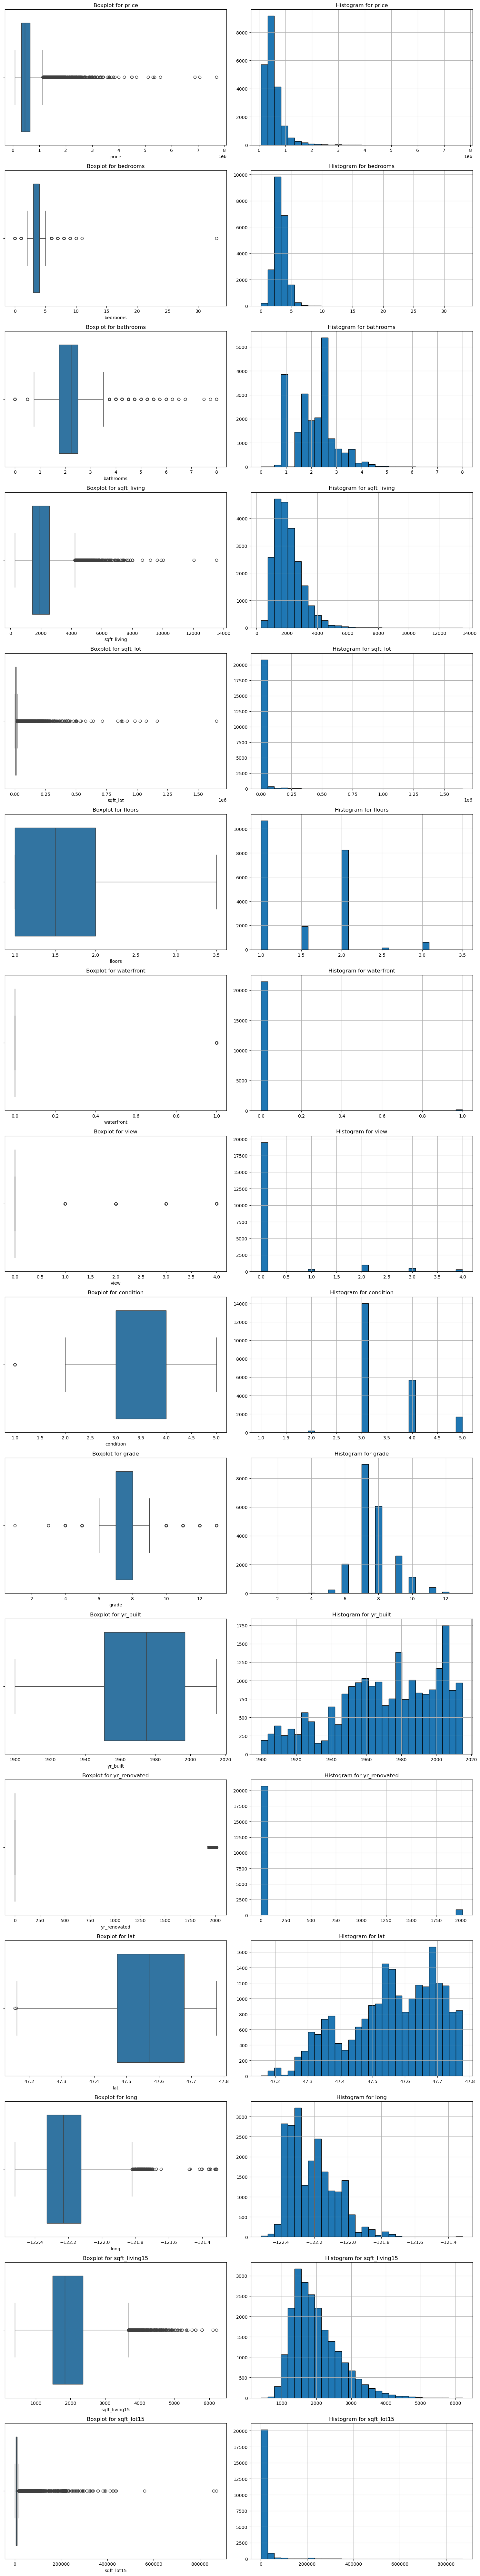

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Boxplot & Histogram combined in a grid:
def visualize_outliers(df):
    """
    Visualizes numerical features in DF using boxplots and histograms to detect potential outliers.

    Parameters:
    df (pandas.DataFrame): The input dataframe containing numerical features.

    Returns:
    None: Displays the plots for each numerical feature.
    """
    num_features = df.select_dtypes(include=['float64', 'int64']).columns
    num_plots = len(num_features)
    
    # Create subplots for Boxplots and Histograms:
    fig, axes = plt.subplots(num_plots, 2, figsize=(15, 5 * num_plots)) 
    
    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i, 0])
        axes[i, 0].set_title(f'Boxplot for {feature}')
        
        df[feature].hist(bins=30, edgecolor='black', ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram for {feature}')
    
    plt.tight_layout()
    plt.show()


# 2. Z-score Method:
def z_score_outliers(df):
    """
    Detects outliers in the dataframe using the Z-score method. Values with a Z-score greater than 3 or less than -3 are considered outliers.

    Parameters:
    df (pandas.DataFrame): The input dataframe containing numerical features.

    Returns:
    dict: A dictionary where keys are feature names and values are lists of indices of the outliers.
    """
    num_features = df.select_dtypes(include=['float64', 'int64']).columns
    outliers = {}
    
    for feature in num_features:
        # Handling missing values by dropping them before calculating Z-scores:
        z_scores = stats.zscore(df[feature].dropna())
        outliers[feature] = np.where(np.abs(z_scores) > 3)[0]
    
    return outliers


# 3. IQR Method:
def iqr_outliers(df):
    """
    Detects outliers in the dataframe using the Interquartile Range (IQR) method. Outliers are values outside of the range defined by 1.5 * IQR above Q3 or below Q1.

    Parameters:
    df (pandas.DataFrame): The input dataframe containing numerical features.

    Returns:
    dict: A dictionary where keys are feature names and values are lists of indices of the outliers.
    """
    num_features = df.select_dtypes(include=['float64', 'int64']).columns
    outliers = {}
    
    for feature in num_features:
        # Calculating the first and third quartiles:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Defining the bounds for outliers:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identifying outliers:
        outliers[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index.tolist()
    
    return outliers


# Apply functions:
visualize_outliers(df)  # Visualize boxplots and histograms.
z_outliers = z_score_outliers(df)  # Detect outliers using Z-score.
iqr_outliers = iqr_outliers(df)  # Detect outliers using IQR.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Identify non-numeric column: 
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns  

# Drop them said columns:
df_cleaned = df.drop(columns=non_numeric_columns)  

# Cap outliers at 10th and 10th percentiles:
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns  
lower_limit = df_cleaned[numeric_columns].quantile(0.10)  
upper_limit = df_cleaned[numeric_columns].quantile(0.90)  

# Apply capping:
for col in numeric_columns:  
    df_cleaned[col] = df_cleaned[col].clip(lower=lower_limit[col], upper=upper_limit[col])  

# Define X (features) and y (target):
X = df_cleaned.drop("price", axis=1)  
y = df_cleaned["price"]  

# Split data into train and test sets (70/30):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

# Train Random Forest:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  
rf_model.fit(X_train, y_train)  

# Make predictions:
predictions = rf_model.predict(X_test)  

# Evaluate performance:
r2 = r2_score(y_test, predictions)  
rmse = np.sqrt(mean_squared_error(y_test, predictions))  
mae = mean_absolute_error(y_test, predictions)  
mse_value = mean_squared_error(y_test, predictions)  

# Print evaluation metrics:
print("R² =", round(r2, 4))  
print("RMSE =", round(rmse, 4))  
print("MAE =", round(mae, 4))  
print("MSE =", round(mse_value, 4))

R² = 0.8796
RMSE = 72415.9004
MAE = 49111.1122
MSE = 5244062624.0535


In [7]:
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Generate synthetic regression data:
X, y = make_regression(n_samples=11000, n_features=5, noise=0.1, random_state=42)  

# Cap outliers in target (y):
lower_bound = np.percentile(y, 10)  
upper_bound = np.percentile(y, 90)  
y_capped = np.clip(y, lower_bound, upper_bound)  

# Split data into train (80%) and test (20%):
X_train, X_test, y_train, y_test = train_test_split(X, y_capped, test_size=0.2, random_state=42)  

# Convert data into DMatrix format:
dtrain = xgb.DMatrix(X_train, label=y_train)  
dtest = xgb.DMatrix(X_test, label=y_test)  

# Train model: 
bst = xgb.train({'objective': 'reg:squarederror'}, dtrain, num_boost_round=100)  

# Make predictions:
predictions = bst.predict(dtest)  

# Evaluate model:
r2 = r2_score(y_test, predictions)  
rmse = np.sqrt(mean_squared_error(y_test, predictions))  
mae = mean_absolute_error(y_test, predictions)  
mse_value = mean_squared_error(y_test, predictions)  

# Evaluation metrics:
print("R² =", round(r2, 4))  
print("RMSE =", round(rmse, 4))  
print("MAE =", round(mae, 4))  
print("MSE =", round(mse_value, 4))

R² = 0.9949
RMSE = 7.5078
MAE = 5.6699
MSE = 56.3666


In [8]:
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score

# Initialize regressor:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)  

# Define RMSE as the scoring metric:
scorer = make_scorer(root_mean_squared_error)  

# Perform 5-fold cross-validation:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)  

# Results:
print(f"Cross-Validation RMSE Scores: {cv_scores}")  
print(f"Mean Cross-Validation RMSE: {cv_scores.mean()}")

Cross-Validation RMSE Scores: [7.89937736 8.03973653 7.53021126 7.48371672 7.8909188 ]
Mean Cross-Validation RMSE: 7.768792133655175


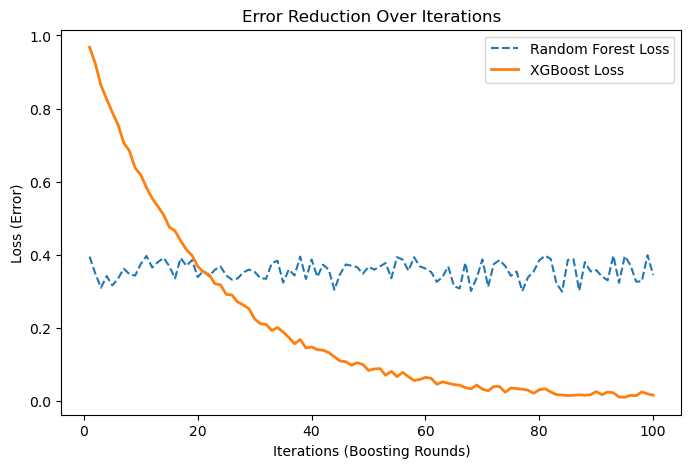

In [9]:
# Example training loss data:
iterations = np.arange(1, 101)
random_forest_loss = np.random.uniform(0.3, 0.4, size=100)  # Random fluctuation
xgboost_loss = np.exp(-iterations / 20) + np.random.uniform(0, 0.02, size=100)  # Exponential decrease

plt.figure(figsize=(8, 5))
plt.plot(iterations, random_forest_loss, label="Random Forest Loss", linestyle="dashed")
plt.plot(iterations, xgboost_loss, label="XGBoost Loss", linewidth=2)
plt.xlabel("Iterations (Boosting Rounds)")
plt.ylabel("Loss (Error)")
plt.title("Error Reduction Over Iterations")
plt.legend()
plt.show()


In [11]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Generate synthetic nonlinear data:
np.random.seed(42)
n_samples = 11000
X = np.random.rand(n_samples, 5) * 10

# Create a nonlinear target variable with interactions:
y = (2 * np.sin(X[:, 0]) +  
     3 * np.log1p(X[:, 1]) +  
     1.5 * (X[:, 2] ** 2) -  
     2 * np.sqrt(X[:, 3] + 1) +  
     0.5 * X[:, 4] * X[:, 2] +  
     np.random.normal(0, 1, n_samples))  # Added noise.

# Cap outliers in target (y):
lower_bound = np.percentile(y, 10)
upper_bound = np.percentile(y, 90)
y_capped = np.clip(y, lower_bound, upper_bound)

# Split data into train (80%) and test (20%):
X_train, X_test, y_train, y_test = train_test_split(X, y_capped, test_size=0.2, random_state=42)

# Convert data into DMatrix format:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train model:
params = {'objective': 'reg:squarederror', 'max_depth': 5, 'learning_rate': 0.1}
bst = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions:
predictions = bst.predict(dtest)

# Evaluate model:
r2 = r2_score(y_test, predictions)  
rmse = np.sqrt(mean_squared_error(y_test, predictions))  
mae = mean_absolute_error(y_test, predictions)  
mse_value = mean_squared_error(y_test, predictions)  

# Evaluation metrics:
print("R² =", round(r2, 4))  
print("RMSE =", round(rmse, 4))  
print("MAE =", round(mae, 4))  
print("MSE =", round(mse_value, 4))


R² = 0.9992
RMSE = 1.3382
MAE = 1.0222
MSE = 1.7906


In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score

# Initialize regressor:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)  

# Define RMSE as the scoring metric:
scorer = make_scorer(root_mean_squared_error)  

# Perform 5-fold cross-validation:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)  

# Results:
print(f"Cross-Validation RMSE Scores: {cv_scores}")  
print(f"Mean Cross-Validation RMSE: {cv_scores.mean()}")

Cross-Validation RMSE Scores: [1.37922061 1.33256087 1.39951909 1.29467021 1.37658649]
Mean Cross-Validation RMSE: 1.3565114548364092
